In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt
import _collections_abc
import sqlite3
import datetime

In [2]:
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by the db_file
    :param db_file: database file
    :return: Connection object or None
    """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
    except Error as e:
        print(e)

    return conn

In [3]:
conn = create_connection('politicians2.db')

In [4]:
curs = conn.cursor()

In [5]:
curs.execute("SELECT name FROM sqlite_master WHERE type = 'table'").fetchall()

[('parliaments',),
 ('parliament_periods',),
 ('parties',),
 ('mandates',),
 ('candidacies',),
 ('politicians',),
 ('Contributor',),
 ('Page',),
 ('Revision',)]

In [6]:
for row in curs.execute("SELECT name FROM sqlite_master WHERE type = 'table'"):
    print(row)

('parliaments',)
('parliament_periods',)
('parties',)
('mandates',)
('candidacies',)
('politicians',)
('Contributor',)
('Page',)
('Revision',)


In [7]:
%%time
#abgeordnete = curs.execute("SELECT * FROM politicians").fetchall()
#parteien = curs.execute("SELECT * FROM parties").fetchall()
#parlamente =  curs.execute("SELECT * FROM parliaments").fetchall() 
#parlamentsperioden = curs.execute("SELECT * FROM parliament_periods").fetchall()
#mandate = curs.execute("SELECT * FROM mandates").fetchall()
#kandidaten = curs.execute("SELECT * FROM candidacies").fetchall()
#contributor = curs.execute("SELECT * FROM Contributor").fetchall()
#artikel = curs.execute("SELECT * FROM Page").fetchall()
#revision = curs.execute("SELECT * FROM Revision").fetchall()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs


# Erstellen der Views

In [8]:
curs.execute("DROP VIEW IF EXISTS change_count")
curs.execute("CREATE VIEW change_count AS SELECT politicians.first_name as Vorname, politicians.last_name as Nachname,  count(page_id) as Changecounter, politicians.id as Politiker_ID  FROM Revision Left JOIN Page  on Revision.page_id = Page.id Left JOIN politicians on Page.politician_id = politicians.id GROUP BY  page_id order by count(page_id) DESC")

In [9]:
curs.execute("DROP VIEW IF EXISTS revision_time")
curs.execute("CREATE VIEW revision_time AS SELECT politicians.first_name as Vorname, politicians.last_name as Nachname, Revision.timestamp, Revision.text_len , politicians.id as Politiker_ID FROM Revision Left JOIN Page on Revision.page_id = Page.id Left JOIN politicians on Page.politician_id = politicians.id ORDER BY politicians.id")

In [10]:
curs.execute("DROP VIEW IF EXISTS party_analysis")
curs.execute("CREATE VIEW party_analysis as SELECT politicians.first_name as Vorname, politicians.last_name as Nachname, Revision.timestamp, Revision.text_len , politicians.id as Politiker_ID, parties.full_name as Partei FROM Revision Left JOIN Page on Revision.page_id = Page.id Left JOIN politicians on Page.politician_id = politicians.id LEFT JOIN parties on politicians.party_id = parties.id")

# Rekord für Anderungen

In [11]:
%%time
print(curs.execute("SELECT Vorname, Nachname, MAX(Changecounter) FROM change_count").fetchone())

('Angela', 'Merkel', 5453)
CPU times: user 168 ms, sys: 53.4 ms, total: 221 ms
Wall time: 222 ms


### und der gewinner ist....

# Angela Merkel

### ..mit sage und schreibe 

## 5453 Änderungen


In [12]:
%%time
query=pd.read_sql("select sum(change_count.Changecounter) FROM change_count ",conn)
print(query)

   sum(change_count.Changecounter)
0                           410819
CPU times: user 299 ms, sys: 56.5 ms, total: 355 ms
Wall time: 379 ms


## Es gibt insgesamt 
# 410819
## Änderungen 

In [13]:
%%time
print(curs.execute("SELECT DISTINCT(Vorname), Nachname FROM revision_time where Nachname is not NULL").fetchmany(5))

[('Stefan', 'Evers'), ('Roland', 'Heintze'), ('Albert', 'Deß'), ('Alexander', 'Graf Lambsdorff'), ('Bernd', 'Posselt')]
CPU times: user 169 ms, sys: 7.49 ms, total: 177 ms
Wall time: 176 ms


In [14]:
%%time 
print(curs.execute("SELECT  revision_time.Vorname, revision_time.Nachname,revision_time.timestamp, change_count.Changecounter FROM revision_time Left JOIN change_count on revision_time.Politiker_ID = change_count.Politiker_ID GROUP BY timestamp ").fetchmany(10))

[('Gabriele', 'Zimmer', '2001-08-25T10:16:55', 159), ('Oskar', 'Lafontaine', '2001-09-24T12:25:16', 2535), ('Angela', 'Merkel', '2001-09-24T12:46:17', 5453), ('Ole', 'von Beust', '2001-09-24T12:54:44', 855), ('Franz', 'Müntefering', '2001-09-24T12:59:51', 1211), ('Fritz', 'Kuhn', '2001-09-24T13:02:45', 403), ('Ute', 'Vogt', '2001-09-24T13:12:20', 345), ('Otto', 'Schily', '2001-09-24T16:14:57', 795), ('Otto', 'Schily', '2001-09-25T12:16:49', 795), ('Otto', 'Schily', '2001-09-25T12:29:34', 795)]
CPU times: user 602 ms, sys: 153 ms, total: 754 ms
Wall time: 758 ms


In [15]:
    %%time 
   
#    x=1
#    rows = curs.execute("SELECT `Vorname`, `Nachname`,timestamp  FROM `revision_time` WHERE (`Vorname` = 'Angela') AND (`Nachname` = 'Merkel') ").fetchall()
#    for row in rows:
#        print(x,row)
#        x=x+1v


    
  

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 3.81 µs


In [16]:
%%time
trampstamp_Merkel = curs.execute("SELECT timestamp FROM `revision_time` WHERE (`Vorname` = 'Angela') AND (`Nachname` = 'Merkel') ").fetchall()
print(trampstamp_Merkel)

[('2001-09-24T12:46:17',), ('2002-08-28T10:50:41',), ('2002-08-29T03:18:58',), ('2002-09-08T22:15:32',), ('2002-10-31T14:53:37',), ('2002-10-31T15:30:28',), ('2002-10-31T17:31:18',), ('2003-01-24T09:23:04',), ('2003-09-27T16:17:57',), ('2003-10-11T20:19:37',), ('2003-11-03T01:26:10',), ('2003-11-03T01:26:45',), ('2003-11-06T17:56:23',), ('2003-11-12T19:52:12',), ('2003-11-17T20:56:21',), ('2003-11-17T20:57:44',), ('2003-11-17T21:02:39',), ('2003-11-18T10:05:31',), ('2003-11-18T12:09:37',), ('2003-11-19T18:28:42',), ('2003-12-03T22:48:37',), ('2003-12-10T15:30:24',), ('2003-12-19T06:05:15',), ('2004-01-01T22:29:27',), ('2004-01-03T00:21:00',), ('2004-01-20T15:07:38',), ('2004-02-06T02:16:41',), ('2004-02-06T02:22:47',), ('2004-02-07T15:28:41',), ('2004-02-07T15:46:13',), ('2004-02-17T14:44:47',), ('2004-02-17T14:47:56',), ('2004-02-17T14:48:45',), ('2004-02-17T14:50:44',), ('2004-02-17T14:51:35',), ('2004-02-17T15:23:37',), ('2004-02-17T15:24:55',), ('2004-02-17T16:20:39',), ('2004-02-1

In [17]:
%%time
Merkel_change_date=[]
for x in trampstamp_Merkel:
    str = ''.join(x)
    Merkel_change_date.append(str[0:10])
    


CPU times: user 1.51 ms, sys: 90 µs, total: 1.6 ms
Wall time: 1.61 ms


In [18]:
%%time
Merkel_date = []
for date in Merkel_change_date:
    datestamp = pd.to_datetime(date, format="%Y-%m-%d")
    Merkel_date.append(datestamp)
print(Merkel_date)

[Timestamp('2001-09-24 00:00:00'), Timestamp('2002-08-28 00:00:00'), Timestamp('2002-08-29 00:00:00'), Timestamp('2002-09-08 00:00:00'), Timestamp('2002-10-31 00:00:00'), Timestamp('2002-10-31 00:00:00'), Timestamp('2002-10-31 00:00:00'), Timestamp('2003-01-24 00:00:00'), Timestamp('2003-09-27 00:00:00'), Timestamp('2003-10-11 00:00:00'), Timestamp('2003-11-03 00:00:00'), Timestamp('2003-11-03 00:00:00'), Timestamp('2003-11-06 00:00:00'), Timestamp('2003-11-12 00:00:00'), Timestamp('2003-11-17 00:00:00'), Timestamp('2003-11-17 00:00:00'), Timestamp('2003-11-17 00:00:00'), Timestamp('2003-11-18 00:00:00'), Timestamp('2003-11-18 00:00:00'), Timestamp('2003-11-19 00:00:00'), Timestamp('2003-12-03 00:00:00'), Timestamp('2003-12-10 00:00:00'), Timestamp('2003-12-19 00:00:00'), Timestamp('2004-01-01 00:00:00'), Timestamp('2004-01-03 00:00:00'), Timestamp('2004-01-20 00:00:00'), Timestamp('2004-02-06 00:00:00'), Timestamp('2004-02-06 00:00:00'), Timestamp('2004-02-07 00:00:00'), Timestamp('20

In [19]:
%%time
from collections import Counter


cnt = Counter()
for word in Merkel_change_date:
    cnt[word] += 1


CPU times: user 1.43 ms, sys: 3 µs, total: 1.43 ms
Wall time: 1.43 ms


In [20]:

list = [(k, v) for k, v in cnt.items()]

CPU times: user 48.4 ms, sys: 4.96 ms, total: 53.4 ms
Wall time: 59.8 ms


<AxesSubplot:>

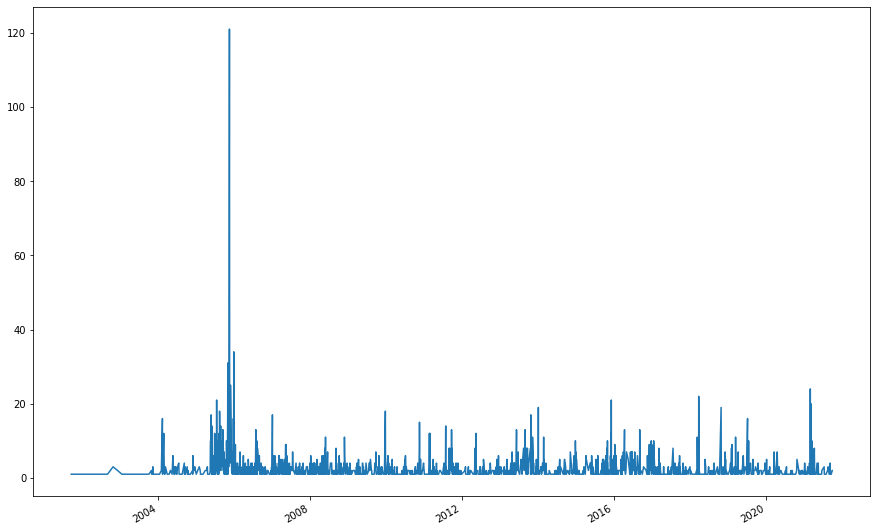

In [21]:
%%time
dyn = pd.DataFrame({'Date':pd.to_datetime(Merkel_change_date)})

s = dyn['Date'].value_counts().sort_index()
plt.gcf().set_size_inches(15, 10)
s.plot()

CPU times: user 114 ms, sys: 13.7 ms, total: 128 ms
Wall time: 103 ms


<AxesSubplot:>

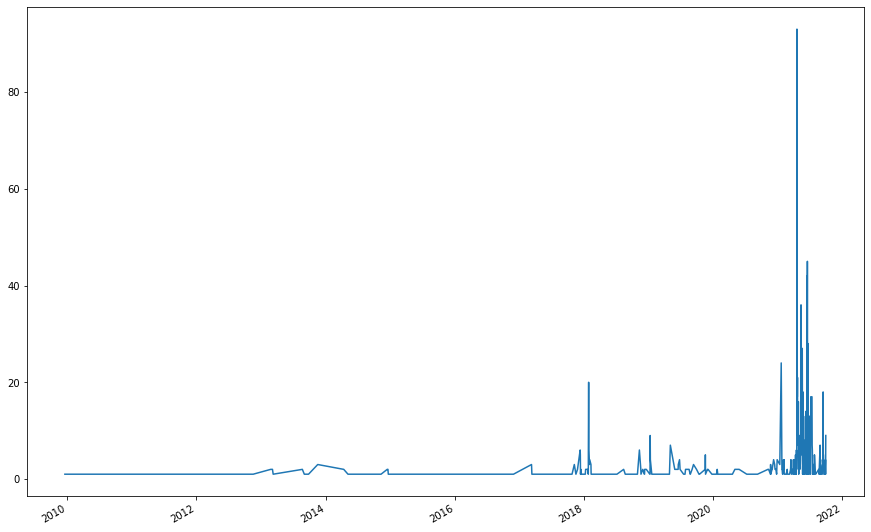

In [22]:
%%time
trampstamp_b = curs.execute("SELECT timestamp FROM `revision_time` WHERE (`Vorname` = 'Annalena') AND (`Nachname` = 'Baerbock') ").fetchall()

b_change_date=[]
for x in trampstamp_b:
    str = ''.join(x)
    b_change_date.append(str[0:10])


baerbock = pd.DataFrame({'Date':pd.to_datetime(b_change_date)})

b = baerbock['Date'].value_counts().sort_index()
plt.gcf().set_size_inches(15, 10)
b.plot()

CPU times: user 944 ms, sys: 140 ms, total: 1.08 s
Wall time: 1.05 s


<AxesSubplot:>

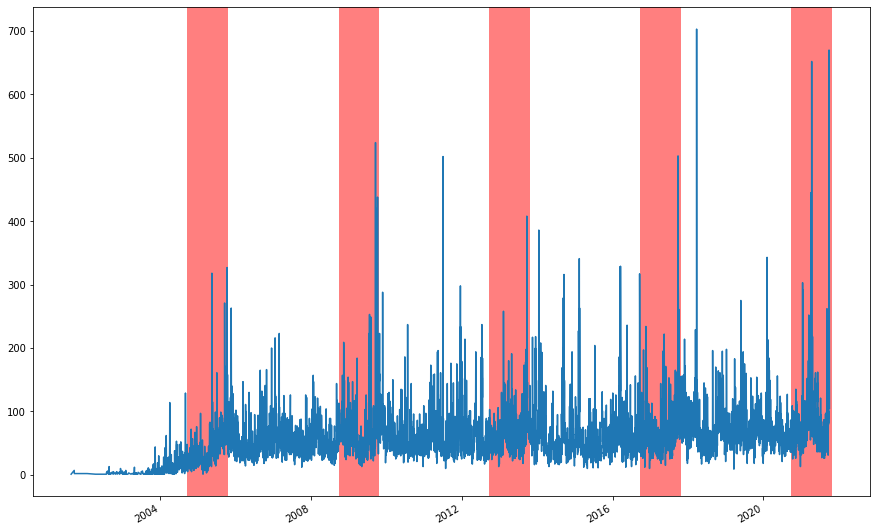

In [23]:
%%time
trampstamp_gesamt = curs.execute("SELECT timestamp FROM `revision_time`  ").fetchall()

g_change_date=[]
for x in trampstamp_gesamt:
    str = ''.join(x)
    g_change_date.append(str[0:10])

gesamt = pd.DataFrame({'Date':pd.to_datetime(g_change_date)})

g = gesamt['Date'].value_counts().sort_index()
plt.gcf().set_size_inches(15, 10)
plt.axvspan(datetime.datetime.strptime("18-09-2004", '%d-%m-%Y'), datetime.datetime.strptime("18-10-2005", '%d-%m-%Y'), alpha=0.5, fill=True, linewidth=0, color='r')
plt.axvspan(datetime.datetime.strptime("27-09-2008", '%d-%m-%Y'), datetime.datetime.strptime("27-10-2009", '%d-%m-%Y'), alpha=0.5, fill=True, linewidth=0, color='r')
plt.axvspan(datetime.datetime.strptime("22-09-2012", '%d-%m-%Y'), datetime.datetime.strptime("22-10-2013", '%d-%m-%Y'), alpha=0.5, fill=True, linewidth=0, color='r')
plt.axvspan(datetime.datetime.strptime("24-09-2016", '%d-%m-%Y'), datetime.datetime.strptime("24-10-2017", '%d-%m-%Y'), alpha=0.5, fill=True, linewidth=0, color='r')
plt.axvspan(datetime.datetime.strptime("26-09-2020", '%d-%m-%Y'), datetime.datetime.strptime("26-10-2021", '%d-%m-%Y'), alpha=0.5, fill=True, linewidth=0, color='r')
g.plot()

CPU times: user 116 ms, sys: 24 ms, total: 140 ms
Wall time: 77 ms


<AxesSubplot:>

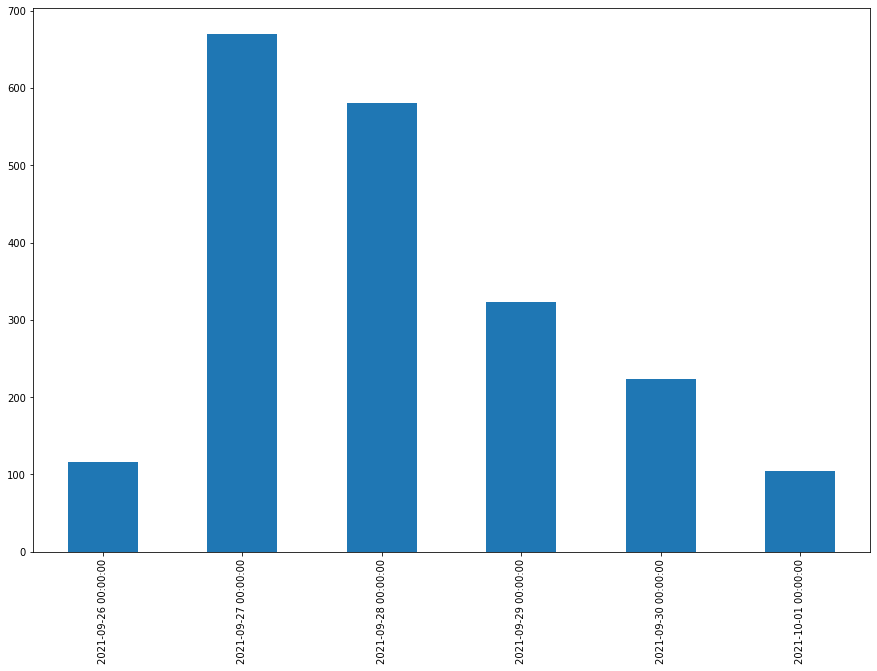

In [24]:
%%time
trampstamp_election = curs.execute("SELECT timestamp FROM `revision_time` WHERE timestamp > '2021-09-26' ").fetchall()

e_change_date=[]
for x in trampstamp_election:
    str = ''.join(x)
    e_change_date.append(str[0:10])

election = pd.DataFrame({'Date':pd.to_datetime(e_change_date)})

e = election['Date'].value_counts().sort_index()
plt.gcf().set_size_inches(15, 10)
e.plot.bar()

CPU times: user 222 ms, sys: 31.3 ms, total: 253 ms
Wall time: 171 ms


<AxesSubplot:>

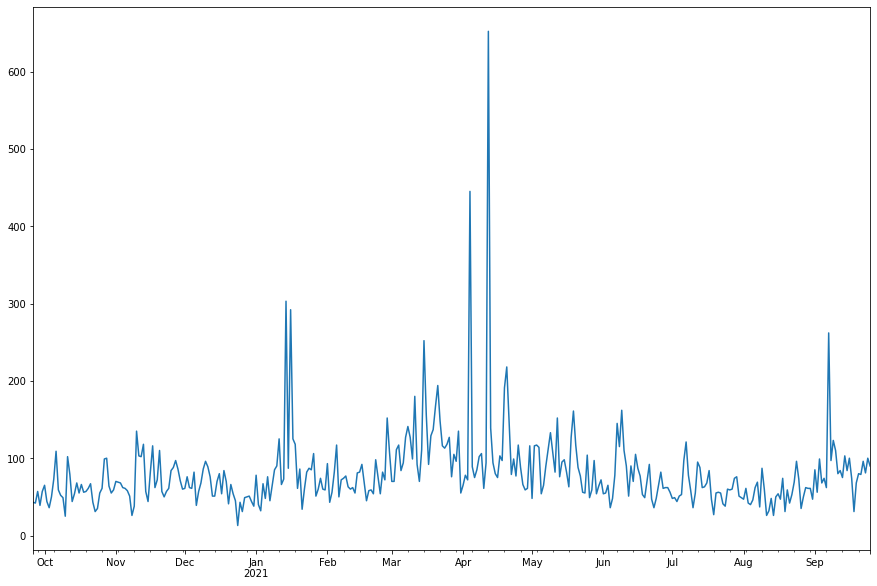

In [25]:
%%time
trampstamp_election1 = curs.execute("SELECT timestamp FROM `revision_time` WHERE timestamp between '2020-09-26' and '2021-09-26' ").fetchall()

e_change_date1=[]
for x in trampstamp_election1:
    str = ''.join(x)
    e_change_date1.append(str[0:10])

election1 = pd.DataFrame({'Date':pd.to_datetime(e_change_date1)})

e1 = election1['Date'].value_counts().sort_index()
plt.gcf().set_size_inches(15, 10)
e1.plot()

CPU times: user 303 ms, sys: 34.2 ms, total: 337 ms
Wall time: 343 ms


<AxesSubplot:>

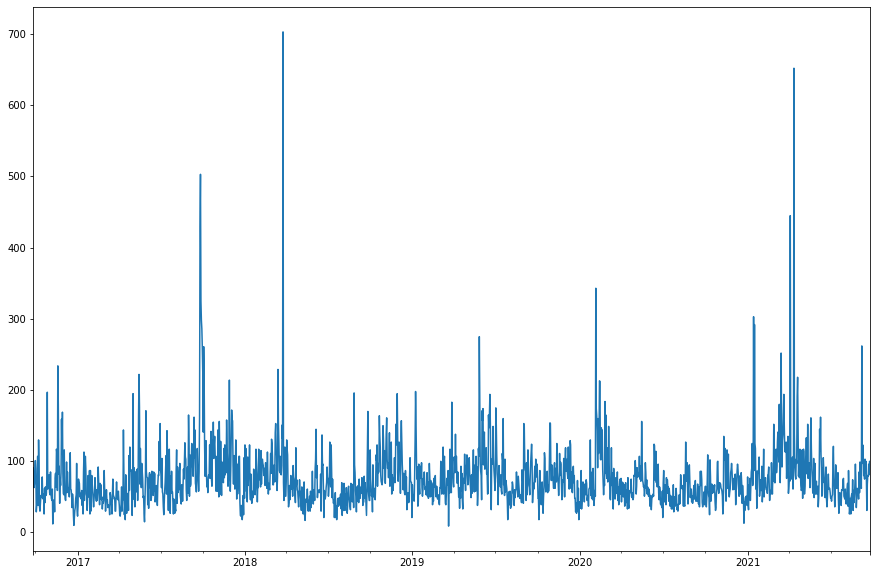

In [26]:
%%time
trampstamp_election2 = curs.execute("SELECT timestamp FROM `revision_time` WHERE timestamp between '2016-09-26' and '2021-09-26' ").fetchall()

e_change_date2=[]
for x in trampstamp_election2:
    str = ''.join(x)
    e_change_date2.append(str[0:10])

election2 = pd.DataFrame({'Date':pd.to_datetime(e_change_date2)})

e2 = election2['Date'].value_counts().sort_index()
plt.gcf().set_size_inches(15, 10)
e2.plot()

In [27]:
%%time
trampstamp_new = curs.execute("SELECT timestamp FROM `party_analysis`  ").fetchall()

n_change_date=[]
for x in trampstamp_new:
    str = ''.join(x)
    n_change_date.append(str[0:10])

new = pd.DataFrame({'Date':pd.to_datetime(g_change_date)})

CPU times: user 538 ms, sys: 58.2 ms, total: 596 ms
Wall time: 546 ms


<AxesSubplot:xlabel='Partei'>

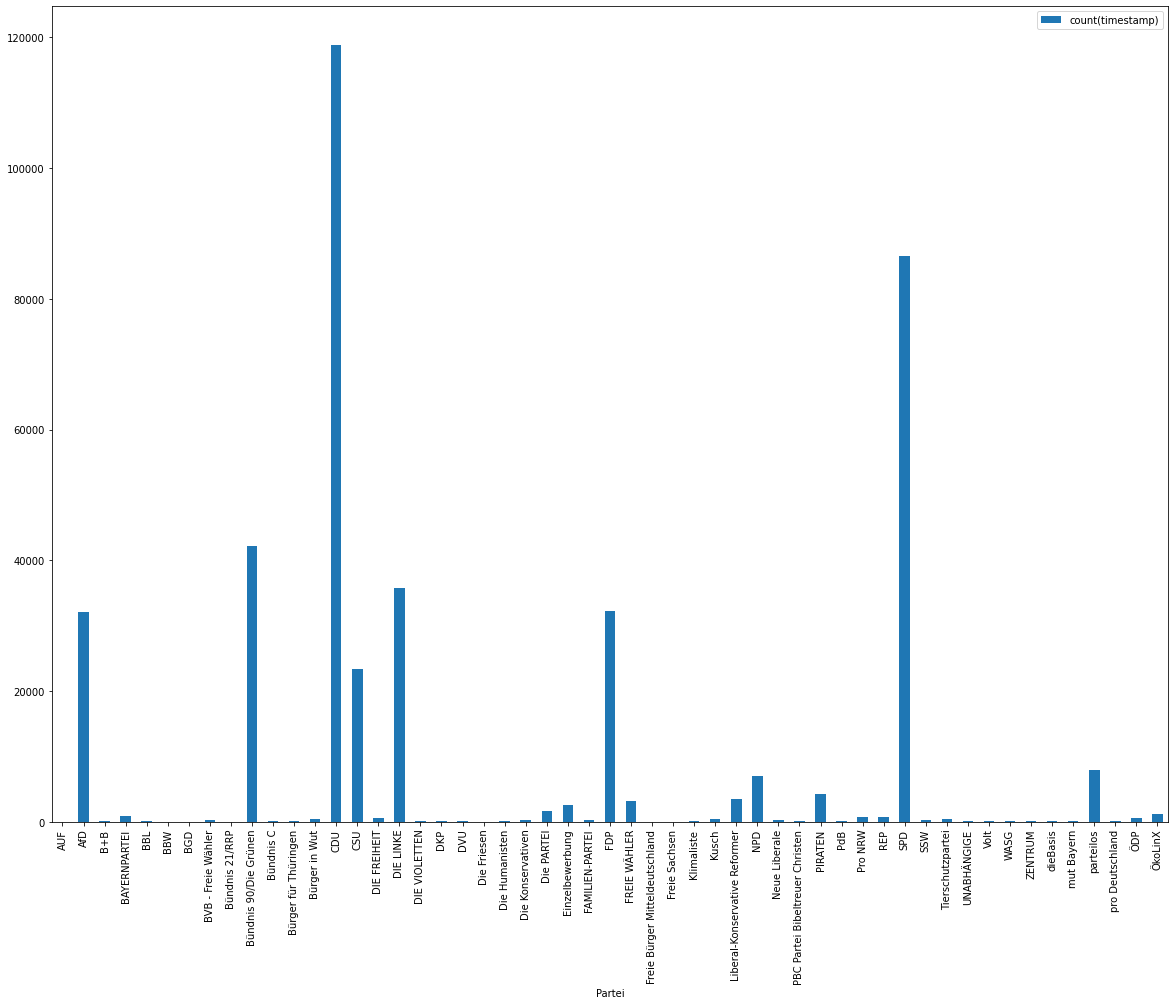

In [28]:
party=pd.read_sql("select count(timestamp), Partei FROM party_analysis group by Partei", conn)
party.groupby(['Partei']).sum().plot(kind='bar',y='count(timestamp)',figsize=(20, 15))

In [29]:
#print(party)

<AxesSubplot:xlabel='Partei'>

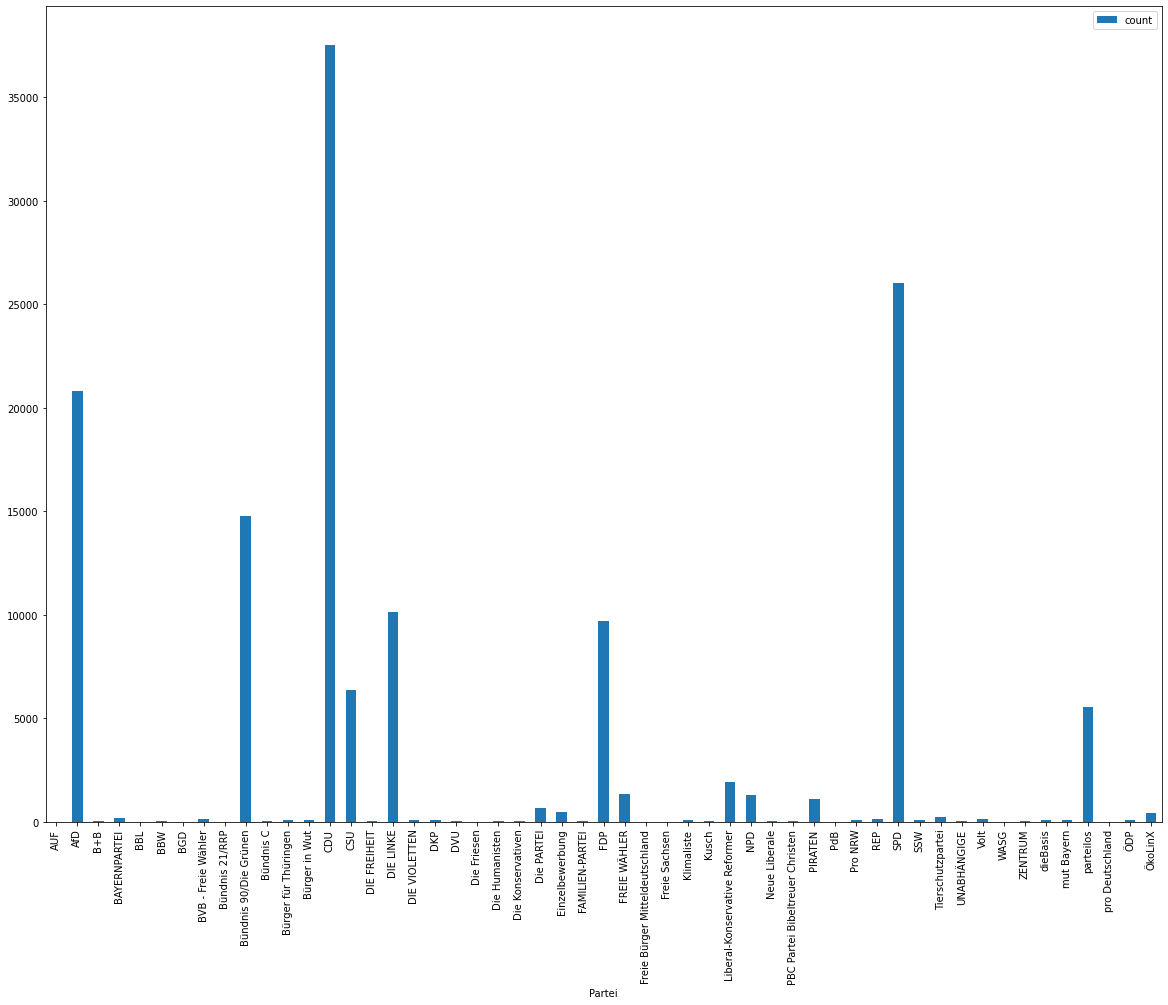

In [30]:
partey=pd.read_sql("select count(timestamp) as count, Partei FROM party_analysis where timestamp between '2016-09-26' and '2021-10-01' group by Partei", conn, columns=['Partei', 'count'])

partey.groupby(['Partei']).sum().plot(kind='bar',y='count',figsize=(20, 15)) 

In [31]:
ja=[tuple(r) for r in partey.to_numpy()]
nein=[]
for i in ja:
      if i[0]>5000: nein.append(i[1])
print(nein)

['AfD', 'Bündnis 90/Die Grünen', 'CDU', 'CSU', 'DIE LINKE', 'FDP', 'SPD', 'parteilos']


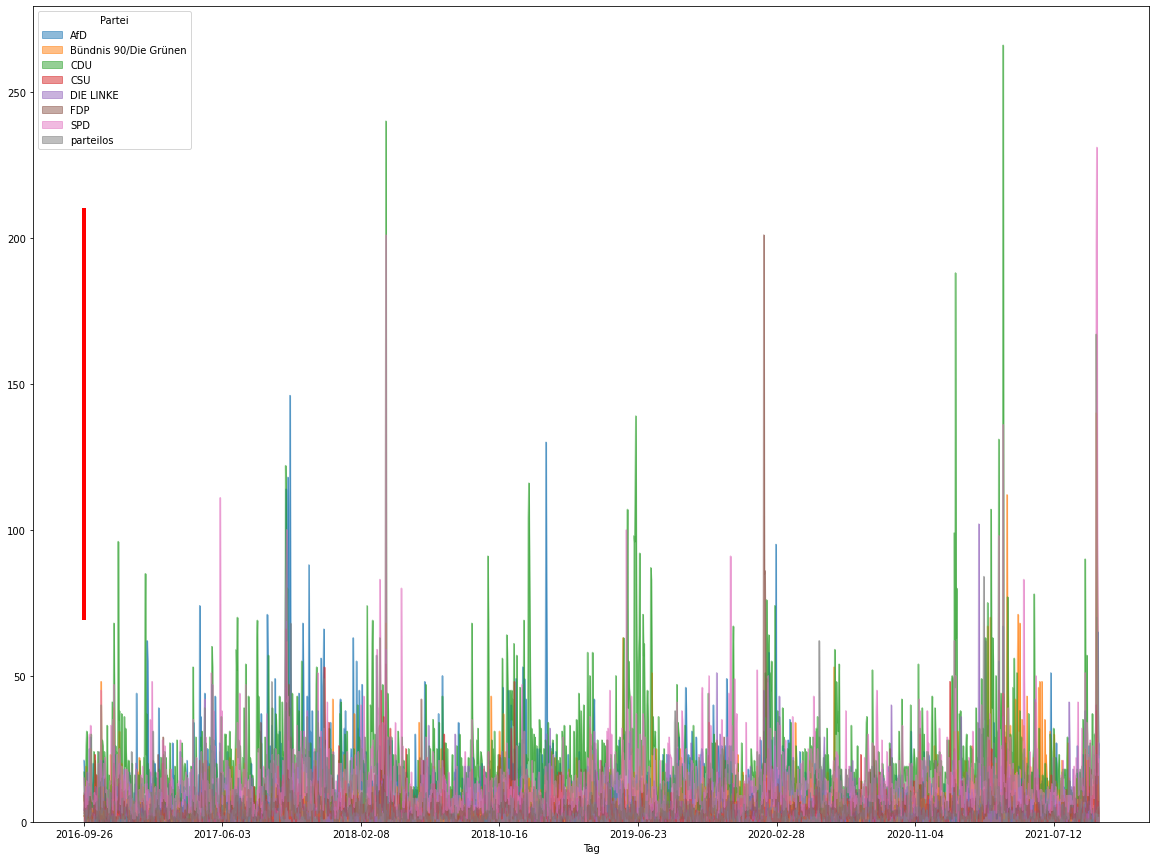

CPU times: user 1.77 s, sys: 260 ms, total: 2.03 s
Wall time: 2.04 s


In [32]:
%%time 
SQL_Query = pd.read_sql_query(
        '''select Partei, date(timestamp) as Tag FROM party_analysis''', conn)
df = pd.DataFrame(SQL_Query, columns=['Partei', 'Tag'])
a = df.pivot_table(columns=['Partei'], index=['Tag'], aggfunc='size').fillna(0)

a.filter(items=nein).loc[a.index.to_series().between('2016-09-26','2021-10-01')].plot(kind='area',stacked=False, figsize=(20, 15)).axvline(linewidth=4, color='r', x='2020-11-15', ymin=0.25, ymax=0.75)
plt.show(block=True);